# Conclusions
to improve results the following experiments shouled be run and tracked:
* find more variabes that describe customers 
* check various sampling strategies
* determine what level of precision and recall are acceptable

In [1]:
import pandas as pd
import numpy as np
from plotnine import *
import seaborn as sns
    
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.over_sampling import SMOTENC, RandomOverSampler

from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import lightgbm as lgb

from hyperopt import hp, fmin, tpe, Trials, STATUS_OK

from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, average_precision_score
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay, roc_curve, precision_recall_curve

pd.options.display.max_rows = 40
pd.options.display.max_columns = 999999
seed = 12345

In [2]:
import os
os.chdir("..")

# UDFs

In [3]:
def compute_counts_and_share(df, var):
    return df[var].value_counts().to_frame('count').join(
    df[var].value_counts(normalize = True).to_frame('share'))

def convert_object_cols_to_category(df):
    for col in df.columns:
        col_type = df[col].dtype
        if col_type == 'object' or col_type.name == 'category':
            df[col] = df[col].astype('category')
    return df

def get_summary(df, threshold):
    return df.loc[abs(df.thresholds - threshold) == min(abs(df.thresholds - threshold)) ,:]

def reclassify_by_treshold(predictions_proba, treshold):
    return predictions_proba[:,1] > treshold

def compute_f1(precision, recall):
    return (2 * precision * recall) / (precision + recall)

def summarise_metrices(y_test, y_hat):
    print("average_precision test: " + str(round(average_precision_score(y_test, y_hat),2)))
    print("f1 test: " + str(round(f1_score(y_test, y_hat),2)))
    print("precision test: " + str(round(precision_score(y_test, y_hat),2)))
    print("recall test: " + str(round(recall_score(y_test, y_hat),2)))
    
def format_confusion_matrix(y_test, y_hat):
    cm = confusion_matrix(y_test, y_hat)
    cm_matrix = pd.DataFrame(data=cm, 
                             columns=['Actual Positive:1', 'Actual Negative:0'], 
                             index=['Predict Positive:1', 'Predict Negative:0'])

    return sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

def get_rf_feature_imp(rf_model):
    rf_feature_importance = pd.DataFrame({'variable' : rf_model.feature_names_in_.tolist(),
                                          'importance' : rf_model.feature_importances_.tolist()})
    rf_feature_importance = rf_feature_importance.sort_values('importance', ascending = False)
    
    print(ggplot(data = rf_feature_importance)
           + geom_col(aes(x = 'variable', y = 'importance'))
           + theme_light()
           + xlab("variable")
           + ylab("importance")
           + scale_x_discrete(limits=rf_feature_importance.variable)
           + theme(axis_text_x = element_text(angle=90))
          )
    
    
def extract_and_plot_hyperopt_trials(trials):
    results = pd.DataFrame()
    for val in trials.vals:
        results[val] = trials.vals[val]
    results['loss'] = [x['loss'] for x in trials.results]

    for col in results.columns[:-1]:
        print(ggplot(aes(x = results[col], y = results['loss']))
              + geom_point()
              + theme_light())

# Data load

In [4]:
df_merged = pd.read_pickle('data/processed/df_application_record_classified_post_feature_eng.pickle')

In [5]:
df_merged.head()

,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,name_income_type,name_education_type,name_housing_type,occupation_type,cnt_fam_members,amt_income_per_person,age,job_tenure,flag_employed,single_adult,target
id,,,,,,,,,,,,,,,,
5008804,1,1,1,0,427500.0,Working,Higher education,Rented apartment,Unknown,2,213750.0,32.890411,12.443836,1,0,0
5008805,1,1,1,0,427500.0,Working,Higher education,Rented apartment,Unknown,2,213750.0,32.890411,12.443836,1,0,0
5008806,1,1,1,0,112500.0,Working,Secondary / secondary special,House / apartment,Security staff,2,56250.0,58.832877,3.106849,1,0,0
5008810,0,0,1,0,270000.0,Commercial associate,Secondary / secondary special,House / apartment,Sales staff,1,270000.0,52.356164,8.358904,1,1,0
5008811,0,0,1,0,270000.0,Commercial associate,Secondary / secondary special,House / apartment,Sales staff,1,270000.0,52.356164,8.358904,1,1,0


In [6]:
df_merged.shape

(19996, 16)

In [7]:
df_merged.isnull().sum()

code_gender              0
flag_own_car             0
flag_own_realty          0
cnt_children             0
amt_income_total         0
name_income_type         0
name_education_type      0
name_housing_type        0
occupation_type          0
cnt_fam_members          0
amt_income_per_person    0
age                      0
job_tenure               0
flag_employed            0
single_adult             0
target                   0
dtype: int64

compute_counts_and_share# Train test spli

In [8]:
compute_counts_and_share(df_merged, 'target')

,count,share
0,19687,0.984547
1,309,0.015453


# Data preprocessing

In [9]:
y = df_merged['target']
X = df_merged.drop('target', axis = 1)

In [10]:
X.loc[:, X.select_dtypes("object_").columns]

,name_income_type,name_education_type,name_housing_type,occupation_type
id,,,,
5008804,Working,Higher education,Rented apartment,Unknown
5008805,Working,Higher education,Rented apartment,Unknown
5008806,Working,Secondary / secondary special,House / apartment,Security staff
5008810,Commercial associate,Secondary / secondary special,House / apartment,Sales staff
5008811,Commercial associate,Secondary / secondary special,House / apartment,Sales staff
...,...,...,...,...
5149729,Working,Secondary / secondary special,House / apartment,Unknown
5149775,Working,Secondary / secondary special,House / apartment,Laborers
5149834,Commercial associate,Higher education,House / apartment,Medicine staff


## PCA 

In [11]:
X_pca = X.copy()
cat_features = X.select_dtypes("object_").columns

lbl_encode = LabelEncoder()
for i in cat_features:
    X_pca[i] = X_pca[[i]].apply(lbl_encode.fit_transform)
X_pca.loc[:, cat_features].head()
X_pca.head()

,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,name_income_type,name_education_type,name_housing_type,occupation_type,cnt_fam_members,amt_income_per_person,age,job_tenure,flag_employed,single_adult
id,,,,,,,,,,,,,,,
5008804,1,1,1,0,427500.0,4,1,4,17,2,213750.0,32.890411,12.443836,1,0
5008805,1,1,1,0,427500.0,4,1,4,17,2,213750.0,32.890411,12.443836,1,0
5008806,1,1,1,0,112500.0,4,4,1,16,2,56250.0,58.832877,3.106849,1,0
5008810,0,0,1,0,270000.0,0,4,1,14,1,270000.0,52.356164,8.358904,1,1
5008811,0,0,1,0,270000.0,0,4,1,14,1,270000.0,52.356164,8.358904,1,1


In [12]:
scaler = StandardScaler()
cols_to_scale = ['cnt_children', 'amt_income_total', 'cnt_fam_members',
                 'amt_income_per_person', 'age', 'job_tenure']
scaler = scaler.fit(X_pca.loc[:,cols_to_scale])

X_pca.loc[:,cols_to_scale] = scaler.transform(X_pca.loc[:,cols_to_scale])

In [13]:
pca = PCA()
X_components = pca.fit_transform(X_pca)
X_components = X_components[:, 0:3]

# # Convert to dataframe
component_names = [f"PC{i+1}" for i in range(X_components.shape[1])]
component_names
X_components = pd.DataFrame(X_components, columns=component_names)
X_components
X = pd.concat([X, X_components.set_index(X.index)], axis=1)

## Data split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=0.2,
                                                    random_state = 123)

## Scaling

In [15]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15996 entries, 5023331 to 5135631
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   code_gender            15996 non-null  int32  
 1   flag_own_car           15996 non-null  int32  
 2   flag_own_realty        15996 non-null  int32  
 3   cnt_children           15996 non-null  int32  
 4   amt_income_total       15996 non-null  float64
 5   name_income_type       15996 non-null  object 
 6   name_education_type    15996 non-null  object 
 7   name_housing_type      15996 non-null  object 
 8   occupation_type        15996 non-null  object 
 9   cnt_fam_members        15996 non-null  int32  
 10  amt_income_per_person  15996 non-null  float64
 11  age                    15996 non-null  float64
 12  job_tenure             15996 non-null  float64
 13  flag_employed          15996 non-null  int32  
 14  single_adult           15996 non-null  int32  

In [16]:
X_train.describe()

,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,cnt_fam_members,amt_income_per_person,age,job_tenure,flag_employed,single_adult,PC1,PC2,PC3
count,15996.000000,15996.000000,15996.000000,15996.000000,1.599600e+04,15996.00000,15996.000000,15996.000000,15996.000000,15996.000000,15996.000000,15996.000000,15996.000000,15996.000000
mean,0.335021,0.388097,0.659227,0.432796,1.876312e+05,2.21049,99992.469870,44.137656,6.196185,0.837709,0.222993,0.001580,0.007490,0.000492
std,0.472013,0.487332,0.473984,0.736354,1.017679e+05,0.90327,71653.033018,11.292522,6.848725,0.368729,0.416267,5.652600,1.764610,1.495467
min,0.000000,0.000000,0.000000,0.000000,2.700000e+04,1.00000,9000.000000,21.252055,-1.000000,0.000000,0.000000,-7.687200,-6.307790,-7.522878
25%,0.000000,0.000000,0.000000,0.000000,1.215000e+05,2.00000,56250.000000,34.602740,1.200000,1.000000,0.000000,-6.314600,-1.401220,-1.003496
50%,0.000000,0.000000,1.000000,0.000000,1.575000e+05,2.00000,78750.000000,43.139726,4.597260,1.000000,0.000000,0.544931,0.288792,-0.102796
75%,1.000000,1.000000,1.000000,1.000000,2.250000e+05,3.00000,123750.000000,53.375342,8.934932,1.000000,0.000000,4.564596,1.520291,0.785698
max,1.000000,1.000000,1.000000,14.000000,1.575000e+06,15.00000,900000.000000,68.909589,42.906849,1.000000,1.000000,10.831413,7.733730,16.786272


In [17]:
scaler = StandardScaler()
cols_to_scale = [ 'cnt_children', 'amt_income_total', 'cnt_fam_members',
                 'amt_income_per_person', 'age', 'job_tenure',
                 'PC1', 'PC2', 'PC3']
scaler = scaler.fit(X_train.loc[:,cols_to_scale])

X_train.loc[:,cols_to_scale] = scaler.transform(X_train.loc[:,cols_to_scale])
X_test.loc[:,cols_to_scale] = scaler.transform(X_test.loc[:,cols_to_scale])

## Sampling

In [18]:
compute_counts_and_share(pd.DataFrame({'target': y_train}), 'target')

,count,share
0,15749,0.984559
1,247,0.015441


In [19]:
undersample = RandomUnderSampler(sampling_strategy = 0.1)
X_train_balanced, y_train_balanced = undersample.fit_resample(X_train, y_train)

In [20]:
compute_counts_and_share(pd.DataFrame({'target': y_train_balanced}), 'target')

,count,share
0,2470,0.909091
1,247,0.090909


In [21]:
# oversample = SMOTENC(random_state=seed,
#                      sampling_strategy = 0.9,
#                      categorical_features=[X_train.columns.isin(['name_income_type', 'name_education_type',
#                                                                  'name_housing_type', 'occupation_type'])])

oversample = RandomOverSampler(random_state=seed,
                     sampling_strategy = 0.9)

X_train_balanced, y_train_balanced = oversample.fit_resample(X_train_balanced, y_train_balanced)

In [22]:
compute_counts_and_share(pd.DataFrame({'target': y_train_balanced}), 'target')

,count,share
0,2470,0.526316
1,2223,0.473684


## One hot encoding

In [23]:
enc = OneHotEncoder(handle_unknown = 'infrequent_if_exist', min_frequency = 300)
enc = enc.fit(X_train_balanced)

In [24]:
X_train_balanced_one_hot = enc.transform(X_train_balanced).toarray()
X_test_one_hot = enc.transform(X_test).toarray()

In [25]:
X_train_balanced_one_hot = pd.DataFrame(X_train_balanced_one_hot,
                                        columns = enc.get_feature_names_out().tolist())
X_test_one_hot = pd.DataFrame(X_test_one_hot,
                                        columns = enc.get_feature_names_out().tolist())
type(X_train_balanced_one_hot)

pandas.core.frame.DataFrame

## Under-sampling: Tomek links

In [26]:
undersample_tomek = TomekLinks(sampling_strategy = 'majority')
(X_train_balanced_one_hot, y_train_balanced_one_hot) = undersample_tomek.fit_resample(X_train_balanced_one_hot, y_train_balanced)

In [27]:
compute_counts_and_share(pd.DataFrame({'target': y_train_balanced_one_hot}), 'target')

,count,share
0,2470,0.526316
1,2223,0.473684


# Modelling

## Try different models with default parameters

In [28]:
classifiers = {
    "LogisticRegression" : LogisticRegression(max_iter = 300, class_weight='balanced'),
    "KNeighbors" : KNeighborsClassifier(),
    # "SVC" : SVC(),
    "DecisionTree" : DecisionTreeClassifier(class_weight='balanced'),
    "RandomForest" : RandomForestClassifier(class_weight='balanced'),
    "XGBoost" : XGBClassifier(scale_pos_weight=10),
    "LGBMClassifier" : lgb.LGBMClassifier(class_weight='balanced')
}

In [29]:
# from sklearn.model_selection import cross_validate
train_cv_scores = []
test_scores = []

for key, classifier in classifiers.items():
    print(key)
    if key == "LGBMClassifier":
        X_train_data = convert_object_cols_to_category(X_train_balanced)
        y_train_data = y_train_balanced
        X_test_data = convert_object_cols_to_category(X_test)
        y_test_data = y_test

        classifier.fit(X_train_data, y_train_data, categorical_feature = ['name_income_type', 'name_education_type', 'name_housing_type', 'occupation_type'])
    else:
        X_train_data = X_train_balanced_one_hot
        y_train_data = y_train_balanced_one_hot
        X_test_data = X_test_one_hot
        y_test_data = y_test
        
        classifier.fit(X_train_data, y_train_data)
        
    train_cv_score = cross_val_score(classifier, X_train_data, y_train_data, scoring="average_precision", cv = 5).mean()
    train_cv_scores.append(train_cv_score)
    test_predictions = classifier.predict(X_test_data)
    test_score = average_precision_score(y_test_data, test_predictions)
    test_scores.append(test_score)

LogisticRegression
KNeighbors
DecisionTree
RandomForest
XGBoost
LGBMClassifier


C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.


In [30]:
print(train_cv_scores)
print(test_scores)

[0.6147015480577197, 0.8803254457076022, 0.8882081163797377, 0.9444087484102454, 0.9438536857782076, 0.9797263198940598]
[0.016060841763695363, 0.039401242728714966, 0.029523965576199705, 0.03234737860053878, 0.025720041456147168, 0.0681341642228739]


In [31]:
models_comparison = pd.DataFrame({'model': classifiers.keys(), 'train_mean_score': train_cv_scores, 'test_score': test_scores})
models_comparison

,model,train_mean_score,test_score
0,LogisticRegression,0.614702,0.016061
1,KNeighbors,0.880325,0.039401
2,DecisionTree,0.888208,0.029524
3,RandomForest,0.944409,0.032347
4,XGBoost,0.943854,0.025720
5,LGBMClassifier,0.979726,0.068134


## AutoML - cannot run on Windows...

In [32]:
# import autosklearn.classification

In [33]:
# automl = autosklearn.classification.AutoSklearnClassifier(
#     time_left_for_this_task=120,
#     per_run_time_limit=30
# )
# automl.fit(X_train_balanced_one_hot, y_train_balanced_one_hot)

In [34]:
# print(automl.leaderboard())

In [35]:
# pprint(automl.show_models(), indent=4)

In [36]:
# test_predictions = classifier.predict(X_test_one_hot)
# summarise_metrices(y_test = y_test, y_hat = test_predictions)

In [37]:
# format_confusion_matrix(y_test, test_predictions)

## Hyperparameter tuning for lgbm

In [38]:
lgbm_reg_params = {
    'n_estimators':     hp.choice('n_estimators', np.arange(5, 3000, 1, dtype=int)),
    'learning_rate':    hp.uniform('learning_rate',0.01, 1),
    'num_leaves':       hp.choice('num_leaves', np.arange(2, 200, 10, dtype=int)),
    'max_depth':        hp.choice('max_depth', np.arange(2, 15, 1, dtype=int)),
    'min_data_in_leaf': hp.choice('min_data_in_leaf', np.arange(50, 10000, 10, dtype=int)),
    'max_bin':          hp.choice('max_bin', np.arange(2, 30, 5, dtype=int)),
    'reg_alpha':        hp.uniform('reg_alpha', 0, 1),
    'reg_lambda':       hp.uniform('reg_lambda', 0, 1)
}

def obj_fun_lgbm(params):
    lgbm = lgb.LGBMClassifier(objective="binary", class_weight='balanced', early_stopping_rounds = None, **params)
    lgbm.fit(X_train_data, y_train_data, categorical_feature = ['name_income_type', 'name_education_type', 'name_housing_type', 'occupation_type'])
    train_cv_score = cross_val_score(lgbm, X_train_data, y_train_data, scoring="average_precision", cv = 5).mean()
    return -1.0 * train_cv_score

X_train_data = convert_object_cols_to_category(X_train_balanced)
y_train_data = y_train_balanced
X_test_data = convert_object_cols_to_category(X_test)
y_test_data = y_test
        
trials_lgbm = Trials()
hyperopt_params_lgbm = fmin(
    fn = obj_fun_lgbm,                     # objective function
    space = lgbm_reg_params,               # parameter space
    algo = tpe.suggest,                    # surrogate algorithm
    max_evals = 100,                       # no. of evaluations
    trials = trials_lgbm,                  # trials object that keeps track of the sample results (optional)
    rstate=np.random.default_rng(seed)
)

[LightGBM] [Warning] min_data_in_leaf is set=3220, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3220                           
[LightGBM] [Warning] min_data_in_leaf is set=3220, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3220                           
  0%|                                                                                                           | 0/100 [00:00<?, ?trial/s, best loss=?]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=3220, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3220                           
[LightGBM] [Warning] min_data_in_leaf is set=3220, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3220                           
[LightGBM] [Warning] min_data_in_leaf is set=3220, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3220                           
[LightGBM] [Warning] min_data_in_leaf is set=810, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=810                             
  1%|▊                                                                              | 1/100 [00:00<01:01,  1.60trial/s, best loss: -0.47368406711308814]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=810, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=810                             
[LightGBM] [Warning] min_data_in_leaf is set=810, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=810                             
[LightGBM] [Warning] min_data_in_leaf is set=810, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=810                             
[LightGBM] [Warning] min_data_in_leaf is set=810, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=810                             
[LightGBM] [Warning] min_data_in_leaf is set=2200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2200                           
  2%|█▌                                                                              | 2/100 [00:03<03:14,  1.98s/trial, best loss: -0.8769829983931524]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=2200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2200                           
[LightGBM] [Warning] min_data_in_leaf is set=2200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2200                           
[LightGBM] [Warning] min_data_in_leaf is set=2200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2200                           
[LightGBM] [Warning] min_data_in_leaf is set=2200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2200                           
[LightGBM] [Warning] min_data_in_leaf is set=8360, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8360                           
  3%|██▍                                                                             | 3/100 [00:04<02:32,  1.57s/trial, best loss: -0.8769829983931524]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=8360, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8360                           
[LightGBM] [Warning] min_data_in_leaf is set=8360, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8360                           
[LightGBM] [Warning] min_data_in_leaf is set=8360, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8360                           
[LightGBM] [Warning] min_data_in_leaf is set=8360, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8360                           
[LightGBM] [Warning] min_data_in_leaf is set=8100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8100                           
  4%|███▏                                                                            | 4/100 [00:05<02:05,  1.31s/trial, best loss: -0.8769829983931524]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=8100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8100                           
[LightGBM] [Warning] min_data_in_leaf is set=8100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8100                           
[LightGBM] [Warning] min_data_in_leaf is set=8100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8100                           
[LightGBM] [Warning] min_data_in_leaf is set=8100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8100                           
[LightGBM] [Warning] min_data_in_leaf is set=4200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4200                           
  5%|████                                                                            | 5/100 [00:07<02:01,  1.28s/trial, best loss: -0.8769829983931524]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=4200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4200                           
[LightGBM] [Warning] min_data_in_leaf is set=4200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4200                           
[LightGBM] [Warning] min_data_in_leaf is set=4200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4200                           
[LightGBM] [Warning] min_data_in_leaf is set=4200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4200                           
[LightGBM] [Warning] min_data_in_leaf is set=6420, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6420                           
  6%|████▊                                                                           | 6/100 [00:08<01:54,  1.22s/trial, best loss: -0.8769829983931524]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=6420, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6420                           
[LightGBM] [Warning] min_data_in_leaf is set=6420, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6420                           
[LightGBM] [Warning] min_data_in_leaf is set=6420, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6420                           
[LightGBM] [Warning] min_data_in_leaf is set=6420, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6420                           
[LightGBM] [Warning] min_data_in_leaf is set=2790, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2790                           
[LightGBM] [Warning] min_data_in_leaf is set=2790, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2790                           
  7%|█████▌                                                                       

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=2790, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2790                           
[LightGBM] [Warning] min_data_in_leaf is set=2790, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2790                           
[LightGBM] [Warning] min_data_in_leaf is set=2790, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2790                           
[LightGBM] [Warning] min_data_in_leaf is set=7880, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7880                           
[LightGBM] [Warning] min_data_in_leaf is set=7880, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7880                           
  8%|██████▍                                                                         | 8/100 [00:09<01:28,  1.04trial/s, best loss: -0.8769829983931524]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=7880, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7880                           
[LightGBM] [Warning] min_data_in_leaf is set=7880, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7880                           
[LightGBM] [Warning] min_data_in_leaf is set=7880, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7880                           
[LightGBM] [Warning] min_data_in_leaf is set=2680, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2680                           
  9%|███████▏                                                                        | 9/100 [00:10<01:17,  1.17trial/s, best loss: -0.8769829983931524]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=2680, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2680                           
[LightGBM] [Warning] min_data_in_leaf is set=2680, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2680                           
[LightGBM] [Warning] min_data_in_leaf is set=2680, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2680                           
[LightGBM] [Warning] min_data_in_leaf is set=2680, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2680                           
[LightGBM] [Warning] min_data_in_leaf is set=830, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=830                             
 10%|███████▉                                                                       | 10/100 [00:11<01:17,  1.16trial/s, best loss: -0.8769829983931524]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=830, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=830                             
[LightGBM] [Warning] min_data_in_leaf is set=830, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=830                             
[LightGBM] [Warning] min_data_in_leaf is set=830, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=830                             
[LightGBM] [Warning] min_data_in_leaf is set=830, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=830                             
[LightGBM] [Warning] min_data_in_leaf is set=210, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=210                             
[LightGBM] [Warning] min_data_in_leaf is set=210, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=210                             
 11%|████████▋                                                                    

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=210, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=210                             
[LightGBM] [Warning] min_data_in_leaf is set=210, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=210                             
[LightGBM] [Warning] min_data_in_leaf is set=210, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=210                             
[LightGBM] [Warning] min_data_in_leaf is set=1530, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1530                           
 12%|█████████▍                                                                     | 12/100 [00:13<01:23,  1.05trial/s, best loss: -0.9444437759567267]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=1530, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1530                           
[LightGBM] [Warning] min_data_in_leaf is set=1530, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1530                           
[LightGBM] [Warning] min_data_in_leaf is set=1530, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1530                           
[LightGBM] [Warning] min_data_in_leaf is set=1530, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1530                           
[LightGBM] [Warning] min_data_in_leaf is set=8810, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8810                           
[LightGBM] [Warning] min_data_in_leaf is set=8810, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8810                           
[LightGBM] [Warning] min_data_in_leaf is set=8810, min_child_samples=20 will be ig

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=9840, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9840                           
[LightGBM] [Warning] min_data_in_leaf is set=9840, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9840                           
 14%|███████████                                                                    | 14/100 [00:16<01:40,  1.16s/trial, best loss: -0.9444437759567267]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=9840, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9840                           
[LightGBM] [Warning] min_data_in_leaf is set=9840, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9840                           
[LightGBM] [Warning] min_data_in_leaf is set=9840, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9840                           
[LightGBM] [Warning] min_data_in_leaf is set=9080, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9080                           
[LightGBM] [Warning] min_data_in_leaf is set=9080, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9080                           
[LightGBM] [Warning] min_data_in_leaf is set=9080, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9080                           
[LightGBM] [Warning] min_data_in_leaf is set=9080, min_child_samples=20 will be ig

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=4960, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4960                           
[LightGBM] [Warning] min_data_in_leaf is set=4960, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4960                           
 16%|████████████▋                                                                  | 16/100 [00:17<01:12,  1.15trial/s, best loss: -0.9444437759567267]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=4960, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4960                           
[LightGBM] [Warning] min_data_in_leaf is set=4960, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4960                           
[LightGBM] [Warning] min_data_in_leaf is set=4960, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4960                           
[LightGBM] [Warning] min_data_in_leaf is set=4930, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4930                           
[LightGBM] [Warning] min_data_in_leaf is set=4930, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4930                           
[LightGBM] [Warning] min_data_in_leaf is set=4930, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4930                           
[LightGBM] [Warning] min_data_in_leaf is set=4930, min_child_samples=20 will be ig

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=4930, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4930                           
[LightGBM] [Warning] min_data_in_leaf is set=8530, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8530                           
 18%|██████████████▏                                                                | 18/100 [00:18<00:58,  1.41trial/s, best loss: -0.9444437759567267]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=8530, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8530                           
[LightGBM] [Warning] min_data_in_leaf is set=8530, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8530                           
[LightGBM] [Warning] min_data_in_leaf is set=8530, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8530                           
[LightGBM] [Warning] min_data_in_leaf is set=8530, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8530                           
[LightGBM] [Warning] min_data_in_leaf is set=3390, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3390                           
 19%|███████████████                                                                | 19/100 [00:19<01:07,  1.20trial/s, best loss: -0.9444437759567267]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=3390, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3390                           
[LightGBM] [Warning] min_data_in_leaf is set=3390, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3390                           
[LightGBM] [Warning] min_data_in_leaf is set=3390, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3390                           
[LightGBM] [Warning] min_data_in_leaf is set=3390, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3390                           
[LightGBM] [Warning] min_data_in_leaf is set=720, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=720                             
 20%|███████████████▊                                                               | 20/100 [00:21<01:13,  1.09trial/s, best loss: -0.9444437759567267]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=720, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=720                             
[LightGBM] [Warning] min_data_in_leaf is set=720, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=720                             
[LightGBM] [Warning] min_data_in_leaf is set=720, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=720                             
[LightGBM] [Warning] min_data_in_leaf is set=720, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=720                             
[LightGBM] [Warning] min_data_in_leaf is set=5190, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5190                           
[LightGBM] [Warning] min_data_in_leaf is set=5190, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5190                           
 21%|████████████████▌                                                            

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=5190, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5190                           
[LightGBM] [Warning] min_data_in_leaf is set=5190, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5190                           
[LightGBM] [Warning] min_data_in_leaf is set=5190, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5190                           
[LightGBM] [Warning] min_data_in_leaf is set=590, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=590                             
 22%|█████████████████▍                                                             | 22/100 [00:23<01:25,  1.09s/trial, best loss: -0.9444437759567267]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=590, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=590                             
[LightGBM] [Warning] min_data_in_leaf is set=590, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=590                             
[LightGBM] [Warning] min_data_in_leaf is set=590, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=590                             
[LightGBM] [Warning] min_data_in_leaf is set=590, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=590                             
[LightGBM] [Warning] min_data_in_leaf is set=9830, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9830                           
 23%|██████████████████▏                                                            | 23/100 [00:25<01:35,  1.24s/trial, best loss: -0.9513462348585605]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=9830, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9830                           
[LightGBM] [Warning] min_data_in_leaf is set=9830, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9830                           
[LightGBM] [Warning] min_data_in_leaf is set=9830, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9830                           
[LightGBM] [Warning] min_data_in_leaf is set=9830, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9830                           
[LightGBM] [Warning] min_data_in_leaf is set=1780, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1780                           
 24%|██████████████████▉                                                            | 24/100 [00:26<01:28,  1.17s/trial, best loss: -0.9513462348585605]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=1780, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1780                           
[LightGBM] [Warning] min_data_in_leaf is set=1780, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1780                           
[LightGBM] [Warning] min_data_in_leaf is set=1780, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1780                           
[LightGBM] [Warning] min_data_in_leaf is set=1780, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1780                           
[LightGBM] [Warning] min_data_in_leaf is set=2460, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2460                           
 25%|███████████████████▊                                                           | 25/100 [00:28<01:41,  1.35s/trial, best loss: -0.9513462348585605]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=2460, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2460                           
[LightGBM] [Warning] min_data_in_leaf is set=2460, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2460                           
[LightGBM] [Warning] min_data_in_leaf is set=2460, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2460                           
[LightGBM] [Warning] min_data_in_leaf is set=2460, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2460                           
[LightGBM] [Warning] min_data_in_leaf is set=5710, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5710                           
 26%|████████████████████▌                                                          | 26/100 [00:29<01:31,  1.24s/trial, best loss: -0.9513462348585605]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=5710, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5710                           
[LightGBM] [Warning] min_data_in_leaf is set=5710, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5710                           
[LightGBM] [Warning] min_data_in_leaf is set=5710, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5710                           
[LightGBM] [Warning] min_data_in_leaf is set=5710, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5710                           
[LightGBM] [Warning] min_data_in_leaf is set=8040, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8040                           
[LightGBM] [Warning] min_data_in_leaf is set=8040, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8040                           
 27%|█████████████████████▎                                                       

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=8040, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8040                           
[LightGBM] [Warning] min_data_in_leaf is set=8040, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8040                           
[LightGBM] [Warning] min_data_in_leaf is set=8040, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8040                           
[LightGBM] [Warning] min_data_in_leaf is set=6250, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6250                           
 28%|██████████████████████                                                         | 28/100 [00:30<01:15,  1.04s/trial, best loss: -0.9513462348585605]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=6250, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6250                           
[LightGBM] [Warning] min_data_in_leaf is set=6250, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6250                           
[LightGBM] [Warning] min_data_in_leaf is set=6250, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6250                           
[LightGBM] [Warning] min_data_in_leaf is set=6250, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6250                           
[LightGBM] [Warning] min_data_in_leaf is set=3630, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3630                           
[LightGBM] [Warning] min_data_in_leaf is set=3630, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3630                           
[LightGBM] [Warning] min_data_in_leaf is set=3630, min_child_samples=20 will be ig

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=3630, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3630                           
[LightGBM] [Warning] min_data_in_leaf is set=270, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=270                             
 30%|███████████████████████▋                                                       | 30/100 [00:32<01:01,  1.14trial/s, best loss: -0.9513462348585605]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=270, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=270                             
[LightGBM] [Warning] min_data_in_leaf is set=270, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=270                             
[LightGBM] [Warning] min_data_in_leaf is set=270, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=270                             
[LightGBM] [Warning] min_data_in_leaf is set=270, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=270                             
[LightGBM] [Warning] min_data_in_leaf is set=7260, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7260                           
[LightGBM] [Warning] min_data_in_leaf is set=7260, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7260                           
[LightGBM] [Warning] min_data_in_leaf is set=7260, min_child_samples=20 will be ig

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=7260, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7260                           
[LightGBM] [Warning] min_data_in_leaf is set=6450, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6450                           
[LightGBM] [Warning] min_data_in_leaf is set=6450, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6450                           
[LightGBM] [Warning] min_data_in_leaf is set=6450, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6450                           
[LightGBM] [Warning] min_data_in_leaf is set=6450, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6450                           
[LightGBM] [Warning] min_data_in_leaf is set=6450, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6450                           
 33%|██████████████████████████                                                   

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400                             
 33%|██████████████████████████                                                     | 33/100 [00:37<01:12,  1.08s/trial, best loss: -0.9726512496471532]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400                             
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400                             
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400                             
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400                             
[LightGBM] [Warning] min_data_in_leaf is set=5250, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5250                           
[LightGBM] [Warning] min_data_in_leaf is set=5250, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5250                           
[LightGBM] [Warning] min_data_in_leaf is set=5250, min_child_samples=20 will be ig

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=5250, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5250                           
[LightGBM] [Warning] min_data_in_leaf is set=5250, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5250                           
[LightGBM] [Warning] min_data_in_leaf is set=270, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=270                             
 35%|███████████████████████████▋                                                   | 35/100 [00:41<01:38,  1.52s/trial, best loss: -0.9726512496471532]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=270, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=270                             
[LightGBM] [Warning] min_data_in_leaf is set=270, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=270                             
[LightGBM] [Warning] min_data_in_leaf is set=270, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=270                             
[LightGBM] [Warning] min_data_in_leaf is set=270, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=270                             
[LightGBM] [Warning] min_data_in_leaf is set=1040, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1040                           
                                                                                                                                                        

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=1040, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1040
[LightGBM] [Warning] min_data_in_leaf is set=1040, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1040                           
[LightGBM] [Warning] min_data_in_leaf is set=1040, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1040                           
[LightGBM] [Warning] min_data_in_leaf is set=1040, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1040                           
[LightGBM] [Warning] min_data_in_leaf is set=3700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3700                           
[LightGBM] [Warning] min_data_in_leaf is set=3700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3700                           
[LightGBM] [Warning] min_data_in_leaf is set=3700, min_child_samples=20 will be ignored. Current value: min_d

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=3700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3700                           
[LightGBM] [Warning] min_data_in_leaf is set=3700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3700                           
[LightGBM] [Warning] min_data_in_leaf is set=8310, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8310                           
[LightGBM] [Warning] min_data_in_leaf is set=8310, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8310                           
 38%|██████████████████████████████                                                 | 38/100 [00:45<01:14,  1.20s/trial, best loss: -0.9726512496471532]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=8310, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8310                           
[LightGBM] [Warning] min_data_in_leaf is set=8310, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8310                           
[LightGBM] [Warning] min_data_in_leaf is set=8310, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8310                           
[LightGBM] [Warning] min_data_in_leaf is set=5150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5150                           
 39%|██████████████████████████████▊                                                | 39/100 [00:46<01:06,  1.09s/trial, best loss: -0.9726512496471532]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=5150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5150                           
[LightGBM] [Warning] min_data_in_leaf is set=5150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5150                           
[LightGBM] [Warning] min_data_in_leaf is set=5150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5150                           
[LightGBM] [Warning] min_data_in_leaf is set=5150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5150                           
[LightGBM] [Warning] min_data_in_leaf is set=270, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=270                             
 40%|███████████████████████████████▌                                               | 40/100 [00:47<01:02,  1.05s/trial, best loss: -0.9726512496471532]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=270, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=270                             
[LightGBM] [Warning] min_data_in_leaf is set=270, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=270                             
[LightGBM] [Warning] min_data_in_leaf is set=270, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=270                             
[LightGBM] [Warning] min_data_in_leaf is set=270, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=270                             
[LightGBM] [Warning] min_data_in_leaf is set=7310, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7310                           
 41%|████████████████████████████████▍                                              | 41/100 [00:49<01:29,  1.52s/trial, best loss: -0.9726512496471532]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=7310, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7310                           
[LightGBM] [Warning] min_data_in_leaf is set=7310, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7310                           
[LightGBM] [Warning] min_data_in_leaf is set=7310, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7310                           
[LightGBM] [Warning] min_data_in_leaf is set=7310, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7310                           
[LightGBM] [Warning] min_data_in_leaf is set=3880, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3880                           
[LightGBM] [Warning] min_data_in_leaf is set=3880, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3880                           
[LightGBM] [Warning] min_data_in_leaf is set=3880, min_child_samples=20 will be ig

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=3880, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3880                           
[LightGBM] [Warning] min_data_in_leaf is set=3880, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3880                           
[LightGBM] [Warning] min_data_in_leaf is set=2050, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2050                           
[LightGBM] [Warning] min_data_in_leaf is set=2050, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2050                           
[LightGBM] [Warning] min_data_in_leaf is set=2050, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2050                           
[LightGBM] [Warning] min_data_in_leaf is set=2050, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2050                           
[LightGBM] [Warning] min_data_in_leaf is set=2050, min_child_samples=20 will be ig

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=690, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=690                             
 44%|██████████████████████████████████▊                                            | 44/100 [00:51<00:50,  1.10trial/s, best loss: -0.9726512496471532]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=690, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=690                             
[LightGBM] [Warning] min_data_in_leaf is set=690, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=690                             
[LightGBM] [Warning] min_data_in_leaf is set=690, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=690                             
[LightGBM] [Warning] min_data_in_leaf is set=690, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=690                             
[LightGBM] [Warning] min_data_in_leaf is set=7920, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7920                           
[LightGBM] [Warning] min_data_in_leaf is set=7920, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7920                           
[LightGBM] [Warning] min_data_in_leaf is set=7920, min_child_samples=20 will be ig

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=7920, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7920                           
[LightGBM] [Warning] min_data_in_leaf is set=7920, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7920                           
[LightGBM] [Warning] min_data_in_leaf is set=1470, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1470                           
 46%|████████████████████████████████████▎                                          | 46/100 [00:55<01:04,  1.20s/trial, best loss: -0.9726512496471532]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=1470, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1470                           
[LightGBM] [Warning] min_data_in_leaf is set=1470, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1470                           
[LightGBM] [Warning] min_data_in_leaf is set=1470, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1470                           
[LightGBM] [Warning] min_data_in_leaf is set=1470, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1470                           
[LightGBM] [Warning] min_data_in_leaf is set=4540, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4540                           
 47%|█████████████████████████████████████▏                                         | 47/100 [00:56<01:00,  1.15s/trial, best loss: -0.9726512496471532]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=4540, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4540                           
[LightGBM] [Warning] min_data_in_leaf is set=4540, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4540                           
[LightGBM] [Warning] min_data_in_leaf is set=4540, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4540                           
[LightGBM] [Warning] min_data_in_leaf is set=4540, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4540                           
[LightGBM] [Warning] min_data_in_leaf is set=270, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=270                             
 48%|█████████████████████████████████████▉                                         | 48/100 [00:57<00:56,  1.08s/trial, best loss: -0.9726512496471532]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=270, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=270                             
[LightGBM] [Warning] min_data_in_leaf is set=270, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=270                             
[LightGBM] [Warning] min_data_in_leaf is set=270, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=270                             
[LightGBM] [Warning] min_data_in_leaf is set=270, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=270                             
[LightGBM] [Warning] min_data_in_leaf is set=7940, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7940                           
 49%|██████████████████████████████████████▋                                        | 49/100 [01:00<01:27,  1.72s/trial, best loss: -0.9726512496471532]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=7940, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7940                           
[LightGBM] [Warning] min_data_in_leaf is set=7940, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7940                           
[LightGBM] [Warning] min_data_in_leaf is set=7940, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7940                           
[LightGBM] [Warning] min_data_in_leaf is set=7940, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7940                           
[LightGBM] [Warning] min_data_in_leaf is set=4730, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4730                           
 50%|███████████████████████████████████████▌                                       | 50/100 [01:01<01:15,  1.52s/trial, best loss: -0.9726512496471532]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=4730, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4730                           
[LightGBM] [Warning] min_data_in_leaf is set=4730, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4730                           
[LightGBM] [Warning] min_data_in_leaf is set=4730, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4730                           
[LightGBM] [Warning] min_data_in_leaf is set=4730, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4730                           
[LightGBM] [Warning] min_data_in_leaf is set=6300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6300                           
[LightGBM] [Warning] min_data_in_leaf is set=6300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6300                           
[LightGBM] [Warning] min_data_in_leaf is set=6300, min_child_samples=20 will be ig

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=6300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6300                           
[LightGBM] [Warning] min_data_in_leaf is set=990, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=990                             
[LightGBM] [Warning] min_data_in_leaf is set=990, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=990                             
[LightGBM] [Warning] min_data_in_leaf is set=990, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=990                             
 52%|█████████████████████████████████████████                                      | 52/100 [01:02<00:50,  1.06s/trial, best loss: -0.9726512496471532]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=990, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=990                             
[LightGBM] [Warning] min_data_in_leaf is set=990, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=990                             
[LightGBM] [Warning] min_data_in_leaf is set=8660, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8660                           
 53%|█████████████████████████████████████████▊                                     | 53/100 [01:03<00:42,  1.10trial/s, best loss: -0.9726512496471532]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=8660, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8660                           
[LightGBM] [Warning] min_data_in_leaf is set=8660, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8660                           
[LightGBM] [Warning] min_data_in_leaf is set=8660, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8660                           
[LightGBM] [Warning] min_data_in_leaf is set=8660, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8660                           
[LightGBM] [Warning] min_data_in_leaf is set=730, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=730                             
 54%|██████████████████████████████████████████▋                                    | 54/100 [01:04<00:42,  1.08trial/s, best loss: -0.9726512496471532]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=730, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=730                             
[LightGBM] [Warning] min_data_in_leaf is set=730, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=730                             
[LightGBM] [Warning] min_data_in_leaf is set=730, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=730                             
[LightGBM] [Warning] min_data_in_leaf is set=730, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=730                             
[LightGBM] [Warning] min_data_in_leaf is set=4740, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4740                           
 55%|███████████████████████████████████████████▍                                   | 55/100 [01:06<00:58,  1.29s/trial, best loss: -0.9726512496471532]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=4740, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4740                           
[LightGBM] [Warning] min_data_in_leaf is set=4740, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4740                           
[LightGBM] [Warning] min_data_in_leaf is set=4740, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4740                           
[LightGBM] [Warning] min_data_in_leaf is set=4740, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4740                           
[LightGBM] [Warning] min_data_in_leaf is set=4790, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4790                           
 56%|████████████████████████████████████████████▏                                  | 56/100 [01:07<00:54,  1.24s/trial, best loss: -0.9726512496471532]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=4790, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4790                           
[LightGBM] [Warning] min_data_in_leaf is set=4790, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4790                           
[LightGBM] [Warning] min_data_in_leaf is set=4790, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4790                           
[LightGBM] [Warning] min_data_in_leaf is set=4790, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4790                           
[LightGBM] [Warning] min_data_in_leaf is set=6200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6200                           
[LightGBM] [Warning] min_data_in_leaf is set=6200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6200                           
[LightGBM] [Warning] min_data_in_leaf is set=6200, min_child_samples=20 will be ig

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=6200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6200                           
[LightGBM] [Warning] min_data_in_leaf is set=6200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6200                           
[LightGBM] [Warning] min_data_in_leaf is set=7490, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7490                           
[LightGBM] [Warning] min_data_in_leaf is set=7490, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7490                           
[LightGBM] [Warning] min_data_in_leaf is set=7490, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7490                           
 58%|█████████████████████████████████████████████▊                                 | 58/100 [01:09<00:42,  1.01s/trial, best loss: -0.9726512496471532]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=7490, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7490                           
[LightGBM] [Warning] min_data_in_leaf is set=7490, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7490                           
[LightGBM] [Warning] min_data_in_leaf is set=8030, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8030                           
 59%|██████████████████████████████████████████████▌                                | 59/100 [01:09<00:35,  1.16trial/s, best loss: -0.9726512496471532]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=8030, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8030                           
[LightGBM] [Warning] min_data_in_leaf is set=8030, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8030                           
[LightGBM] [Warning] min_data_in_leaf is set=8030, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8030                           
[LightGBM] [Warning] min_data_in_leaf is set=8030, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8030                           
[LightGBM] [Warning] min_data_in_leaf is set=8400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8400                           
[LightGBM] [Warning] min_data_in_leaf is set=8400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8400                           
[LightGBM] [Warning] min_data_in_leaf is set=8400, min_child_samples=20 will be ig

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=8400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8400                           
[LightGBM] [Warning] min_data_in_leaf is set=6190, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6190                           
 61%|████████████████████████████████████████████████▏                              | 61/100 [01:11<00:30,  1.30trial/s, best loss: -0.9726512496471532]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=6190, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6190                           
[LightGBM] [Warning] min_data_in_leaf is set=6190, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6190                           
[LightGBM] [Warning] min_data_in_leaf is set=6190, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6190                           
[LightGBM] [Warning] min_data_in_leaf is set=6190, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6190                           
[LightGBM] [Warning] min_data_in_leaf is set=2640, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2640                           
[LightGBM] [Warning] min_data_in_leaf is set=2640, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2640                           
[LightGBM] [Warning] min_data_in_leaf is set=2640, min_child_samples=20 will be ig

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=2640, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2640                           
[LightGBM] [Warning] min_data_in_leaf is set=4180, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4180                           
[LightGBM] [Warning] min_data_in_leaf is set=4180, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4180                           
[LightGBM] [Warning] min_data_in_leaf is set=4180, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4180                           
 63%|█████████████████████████████████████████████████▊                             | 63/100 [01:12<00:28,  1.32trial/s, best loss: -0.9726512496471532]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=4180, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4180                           
[LightGBM] [Warning] min_data_in_leaf is set=4180, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4180                           
[LightGBM] [Warning] min_data_in_leaf is set=6780, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6780                           
[LightGBM] [Warning] min_data_in_leaf is set=6780, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6780                           
 64%|██████████████████████████████████████████████████▌                            | 64/100 [01:13<00:25,  1.41trial/s, best loss: -0.9726512496471532]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=6780, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6780                           
[LightGBM] [Warning] min_data_in_leaf is set=6780, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6780                           
[LightGBM] [Warning] min_data_in_leaf is set=6780, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6780                           
[LightGBM] [Warning] min_data_in_leaf is set=1120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1120                           
 65%|███████████████████████████████████████████████████▎                           | 65/100 [01:13<00:24,  1.44trial/s, best loss: -0.9726512496471532]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=1120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1120                           
[LightGBM] [Warning] min_data_in_leaf is set=1120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1120                           
[LightGBM] [Warning] min_data_in_leaf is set=1120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1120                           
[LightGBM] [Warning] min_data_in_leaf is set=1120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1120                           
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100                           
 66%|████████████████████████████████████████████████████▏                          | 66/100 [01:15<00:35,  1.05s/trial, best loss: -0.9726512496471532]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100                           
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100                           
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100                           
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100                           
[LightGBM] [Warning] min_data_in_leaf is set=1360, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1360                           
[LightGBM] [Warning] min_data_in_leaf is set=1360, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1360                           
[LightGBM] [Warning] min_data_in_leaf is set=1360, min_child_samples=20 will be ig

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=1360, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1360                           
[LightGBM] [Warning] min_data_in_leaf is set=1360, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1360                           
[LightGBM] [Warning] min_data_in_leaf is set=4420, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4420                           
 68%|█████████████████████████████████████████████████████▋                         | 68/100 [01:18<00:34,  1.09s/trial, best loss: -0.9726512496471532]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=4420, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4420                           
[LightGBM] [Warning] min_data_in_leaf is set=4420, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4420                           
[LightGBM] [Warning] min_data_in_leaf is set=4420, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4420                           
[LightGBM] [Warning] min_data_in_leaf is set=4420, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4420                           
[LightGBM] [Warning] min_data_in_leaf is set=6120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6120                           
 69%|██████████████████████████████████████████████████████▌                        | 69/100 [01:19<00:30,  1.01trial/s, best loss: -0.9726512496471532]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=6120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6120                           
[LightGBM] [Warning] min_data_in_leaf is set=6120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6120                           
[LightGBM] [Warning] min_data_in_leaf is set=6120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6120                           
[LightGBM] [Warning] min_data_in_leaf is set=6120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6120                           
[LightGBM] [Warning] min_data_in_leaf is set=270, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=270                             
 70%|███████████████████████████████████████████████████████▎                       | 70/100 [01:19<00:28,  1.06trial/s, best loss: -0.9726512496471532]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=270, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=270                             
[LightGBM] [Warning] min_data_in_leaf is set=270, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=270                             
[LightGBM] [Warning] min_data_in_leaf is set=270, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=270                             
[LightGBM] [Warning] min_data_in_leaf is set=270, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=270                             
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300                             
 71%|████████████████████████████████████████████████████████                       | 71/100 [01:24<01:01,  2.12s/trial, best loss: -0.9726512496471532]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300                             
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300                             
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300                             
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300                             
[LightGBM] [Warning] min_data_in_leaf is set=8370, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8370                           
 72%|████████████████████████████████████████████████████████▉                      | 72/100 [01:26<01:00,  2.16s/trial, best loss: -0.9726512496471532]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=8370, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8370                           
[LightGBM] [Warning] min_data_in_leaf is set=8370, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8370                           
[LightGBM] [Warning] min_data_in_leaf is set=8370, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8370                           
[LightGBM] [Warning] min_data_in_leaf is set=8370, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8370                           
[LightGBM] [Warning] min_data_in_leaf is set=8210, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8210                           
[LightGBM] [Warning] min_data_in_leaf is set=8210, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8210                           
[LightGBM] [Warning] min_data_in_leaf is set=8210, min_child_samples=20 will be ig

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=8210, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8210                           
[LightGBM] [Warning] min_data_in_leaf is set=6680, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6680                           
[LightGBM] [Warning] min_data_in_leaf is set=6680, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6680                           
 74%|██████████████████████████████████████████████████████████▍                    | 74/100 [01:28<00:35,  1.38s/trial, best loss: -0.9726512496471532]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=6680, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6680                           
[LightGBM] [Warning] min_data_in_leaf is set=6680, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6680                           
[LightGBM] [Warning] min_data_in_leaf is set=6680, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6680                           
[LightGBM] [Warning] min_data_in_leaf is set=2800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2800                           
 75%|███████████████████████████████████████████████████████████▎                   | 75/100 [01:28<00:29,  1.17s/trial, best loss: -0.9726512496471532]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=2800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2800                           
[LightGBM] [Warning] min_data_in_leaf is set=2800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2800                           
[LightGBM] [Warning] min_data_in_leaf is set=2800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2800                           
[LightGBM] [Warning] min_data_in_leaf is set=2800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2800                           
[LightGBM] [Warning] min_data_in_leaf is set=7210, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7210                           
 76%|████████████████████████████████████████████████████████████                   | 76/100 [01:29<00:25,  1.08s/trial, best loss: -0.9726512496471532]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=7210, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7210                           
[LightGBM] [Warning] min_data_in_leaf is set=7210, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7210                           
[LightGBM] [Warning] min_data_in_leaf is set=7210, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7210                           
[LightGBM] [Warning] min_data_in_leaf is set=7210, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7210                           
[LightGBM] [Warning] min_data_in_leaf is set=9180, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9180                           
[LightGBM] [Warning] min_data_in_leaf is set=9180, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9180                           
 77%|████████████████████████████████████████████████████████████▊                

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=9180, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9180                           
[LightGBM] [Warning] min_data_in_leaf is set=9180, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9180                           
[LightGBM] [Warning] min_data_in_leaf is set=9180, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9180                           
[LightGBM] [Warning] min_data_in_leaf is set=4920, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4920                           
[LightGBM] [Warning] min_data_in_leaf is set=4920, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4920                           
 78%|█████████████████████████████████████████████████████████████▌                 | 78/100 [01:31<00:21,  1.04trial/s, best loss: -0.9726512496471532]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=4920, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4920                           
[LightGBM] [Warning] min_data_in_leaf is set=4920, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4920                           
[LightGBM] [Warning] min_data_in_leaf is set=4920, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4920                           
[LightGBM] [Warning] min_data_in_leaf is set=8000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8000                           
[LightGBM] [Warning] min_data_in_leaf is set=8000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8000                           
 79%|██████████████████████████████████████████████████████████████▍                | 79/100 [01:32<00:19,  1.10trial/s, best loss: -0.9726512496471532]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=8000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8000                           
[LightGBM] [Warning] min_data_in_leaf is set=8000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8000                           
[LightGBM] [Warning] min_data_in_leaf is set=8000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8000                           
[LightGBM] [Warning] min_data_in_leaf is set=9630, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9630                           
 80%|███████████████████████████████████████████████████████████████▏               | 80/100 [01:33<00:16,  1.19trial/s, best loss: -0.9726512496471532]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=9630, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9630                           
[LightGBM] [Warning] min_data_in_leaf is set=9630, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9630                           
[LightGBM] [Warning] min_data_in_leaf is set=9630, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9630                           
[LightGBM] [Warning] min_data_in_leaf is set=9630, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9630                           
[LightGBM] [Warning] min_data_in_leaf is set=9820, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9820                           
 81%|███████████████████████████████████████████████████████████████▉               | 81/100 [01:33<00:16,  1.18trial/s, best loss: -0.9726512496471532]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=9820, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9820                           
[LightGBM] [Warning] min_data_in_leaf is set=9820, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9820                           
[LightGBM] [Warning] min_data_in_leaf is set=9820, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9820                           
[LightGBM] [Warning] min_data_in_leaf is set=9820, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9820                           
[LightGBM] [Warning] min_data_in_leaf is set=1270, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1270                           
 82%|████████████████████████████████████████████████████████████████▊              | 82/100 [01:34<00:15,  1.14trial/s, best loss: -0.9726512496471532]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=1270, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1270                           
[LightGBM] [Warning] min_data_in_leaf is set=1270, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1270                           
[LightGBM] [Warning] min_data_in_leaf is set=1270, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1270                           
[LightGBM] [Warning] min_data_in_leaf is set=1270, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1270                           
[LightGBM] [Warning] min_data_in_leaf is set=270, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=270                             
 83%|█████████████████████████████████████████████████████████████████▌             | 83/100 [01:36<00:17,  1.00s/trial, best loss: -0.9726512496471532]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=270, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=270                             
[LightGBM] [Warning] min_data_in_leaf is set=270, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=270                             
[LightGBM] [Warning] min_data_in_leaf is set=270, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=270                             
[LightGBM] [Warning] min_data_in_leaf is set=270, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=270                             
[LightGBM] [Warning] min_data_in_leaf is set=560, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=560                             
 84%|██████████████████████████████████████████████████████████████████▎            | 84/100 [01:38<00:23,  1.48s/trial, best loss: -0.9726512496471532]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=560, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=560                             
[LightGBM] [Warning] min_data_in_leaf is set=560, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=560                             
[LightGBM] [Warning] min_data_in_leaf is set=560, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=560                             
[LightGBM] [Warning] min_data_in_leaf is set=560, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=560                             
[LightGBM] [Warning] min_data_in_leaf is set=4860, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4860                           
[LightGBM] [Warning] min_data_in_leaf is set=4860, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4860                           
[LightGBM] [Warning] min_data_in_leaf is set=4860, min_child_samples=20 will be ig

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=4860, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4860                           
[LightGBM] [Warning] min_data_in_leaf is set=840, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=840                             
 86%|███████████████████████████████████████████████████████████████████▉           | 86/100 [01:42<00:22,  1.60s/trial, best loss: -0.9726512496471532]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=840, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=840                             
[LightGBM] [Warning] min_data_in_leaf is set=840, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=840                             
[LightGBM] [Warning] min_data_in_leaf is set=840, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=840                             
[LightGBM] [Warning] min_data_in_leaf is set=840, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=840                             
[LightGBM] [Warning] min_data_in_leaf is set=4080, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4080                           
[LightGBM] [Warning] min_data_in_leaf is set=4080, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4080                           
[LightGBM] [Warning] min_data_in_leaf is set=4080, min_child_samples=20 will be ig

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=2610, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2610                           
 88%|█████████████████████████████████████████████████████████████████████▌         | 88/100 [01:46<00:20,  1.70s/trial, best loss: -0.9726512496471532]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=2610, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2610                           
[LightGBM] [Warning] min_data_in_leaf is set=2610, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2610                           
[LightGBM] [Warning] min_data_in_leaf is set=2610, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2610                           
[LightGBM] [Warning] min_data_in_leaf is set=2610, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2610                           
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100                             
 89%|██████████████████████████████████████████████████████████████████████▎        | 89/100 [01:47<00:16,  1.50s/trial, best loss: -0.9726512496471532]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100                             
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100                             
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100                             
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100                             
[LightGBM] [Warning] min_data_in_leaf is set=1950, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1950                           
[LightGBM] [Warning] min_data_in_leaf is set=1950, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1950                           
[LightGBM] [Warning] min_data_in_leaf is set=1950, min_child_samples=20 will be ig

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=1950, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1950                           
[LightGBM] [Warning] min_data_in_leaf is set=1950, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1950                           
[LightGBM] [Warning] min_data_in_leaf is set=6270, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6270                           
[LightGBM] [Warning] min_data_in_leaf is set=6270, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6270                           
[LightGBM] [Warning] min_data_in_leaf is set=6270, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6270                           
 91%|████████████████████████████████████████████████████████████████████████▊       | 91/100 [01:53<00:16,  1.88s/trial, best loss: -0.974600182751842]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=6270, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6270                           
[LightGBM] [Warning] min_data_in_leaf is set=6270, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6270                           
[LightGBM] [Warning] min_data_in_leaf is set=9620, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9620                           
[LightGBM] [Warning] min_data_in_leaf is set=9620, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9620                           
 92%|█████████████████████████████████████████████████████████████████████████▌      | 92/100 [01:53<00:11,  1.47s/trial, best loss: -0.974600182751842]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=9620, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9620                           
[LightGBM] [Warning] min_data_in_leaf is set=9620, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9620                           
[LightGBM] [Warning] min_data_in_leaf is set=9620, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9620                           
[LightGBM] [Warning] min_data_in_leaf is set=4590, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4590                           
 93%|██████████████████████████████████████████████████████████████████████████▍     | 93/100 [01:54<00:08,  1.27s/trial, best loss: -0.974600182751842]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=4590, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4590                           
[LightGBM] [Warning] min_data_in_leaf is set=4590, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4590                           
[LightGBM] [Warning] min_data_in_leaf is set=4590, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4590                           
[LightGBM] [Warning] min_data_in_leaf is set=4590, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4590                           
[LightGBM] [Warning] min_data_in_leaf is set=1350, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1350                           
 94%|███████████████████████████████████████████████████████████████████████████▏    | 94/100 [01:55<00:06,  1.14s/trial, best loss: -0.974600182751842]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=1350, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1350                           
[LightGBM] [Warning] min_data_in_leaf is set=1350, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1350                           
[LightGBM] [Warning] min_data_in_leaf is set=1350, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1350                           
[LightGBM] [Warning] min_data_in_leaf is set=1350, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1350                           
[LightGBM] [Warning] min_data_in_leaf is set=4500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4500                           
[LightGBM] [Warning] min_data_in_leaf is set=4500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4500                           
 95%|████████████████████████████████████████████████████████████████████████████ 

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=4500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4500                           
[LightGBM] [Warning] min_data_in_leaf is set=4500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4500                           
[LightGBM] [Warning] min_data_in_leaf is set=4500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4500                           
[LightGBM] [Warning] min_data_in_leaf is set=2360, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2360                           
[LightGBM] [Warning] min_data_in_leaf is set=2360, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2360                           
[LightGBM] [Warning] min_data_in_leaf is set=2360, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2360                           
 96%|████████████████████████████████████████████████████████████████████████████▊

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=2360, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2360                           
[LightGBM] [Warning] min_data_in_leaf is set=2360, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2360                           
[LightGBM] [Warning] min_data_in_leaf is set=8170, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8170                           
[LightGBM] [Warning] min_data_in_leaf is set=8170, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8170                           
[LightGBM] [Warning] min_data_in_leaf is set=8170, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8170                           
[LightGBM] [Warning] min_data_in_leaf is set=8170, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8170                           
 97%|█████████████████████████████████████████████████████████████████████████████

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=8170, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8170                           
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100                             
 98%|██████████████████████████████████████████████████████████████████████████████▍ | 98/100 [01:59<00:01,  1.08trial/s, best loss: -0.974600182751842]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100                             
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100                             
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100                             
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100                             
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800                             
 99%|███████████████████████████████████████████████████████████████████████████████▏| 99/100 [02:00<00:00,  1.08trial/s, best loss: -0.974600182751842]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800                             
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800                             
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800                             
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800                             
100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [02:02<00:00,  1.23s/trial, best loss: -0.974600182751842]


In [39]:
hyperopt_params_lgbm

{'learning_rate': 0.11896361988417897,
 'max_bin': 2,
 'max_depth': 10,
 'min_data_in_leaf': 5,
 'n_estimators': 1317,
 'num_leaves': 18,
 'reg_alpha': 0.21374679841071625,
 'reg_lambda': 0.7184760864059272}

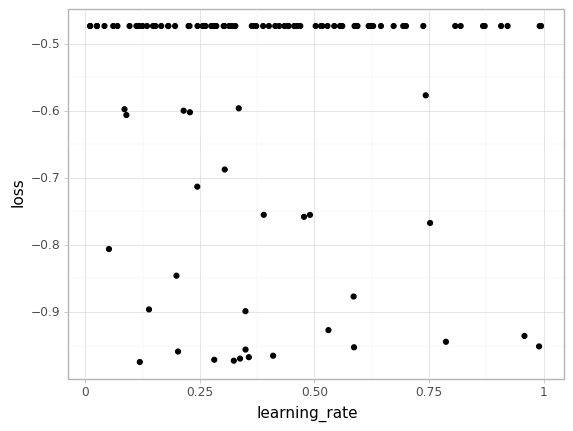

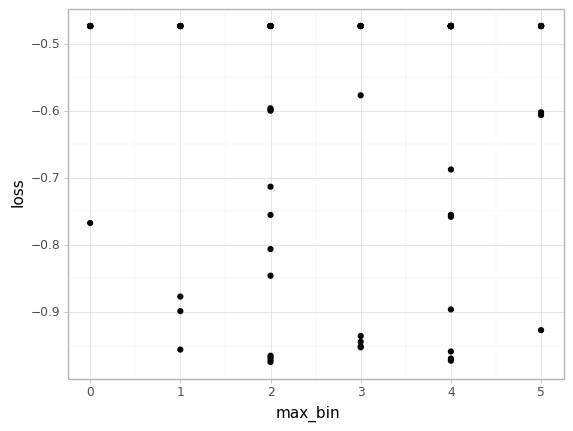

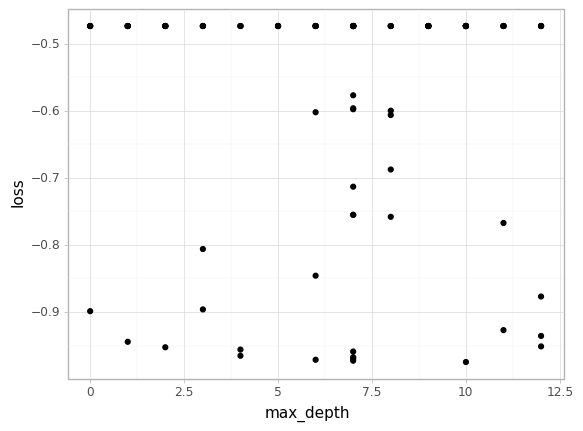

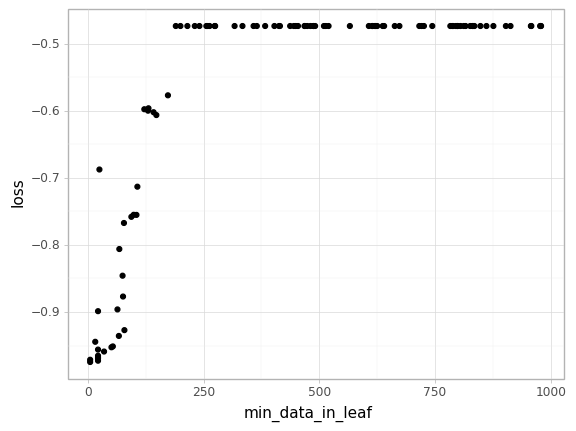

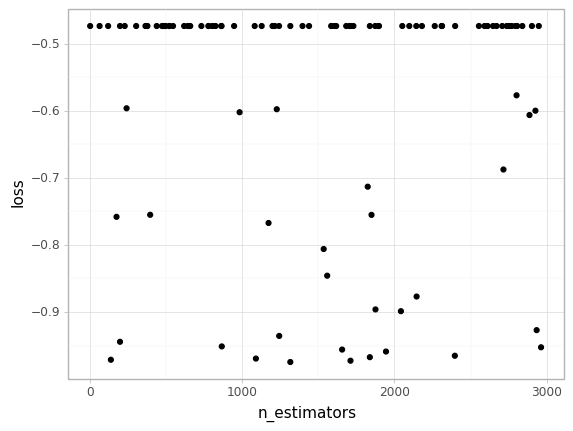

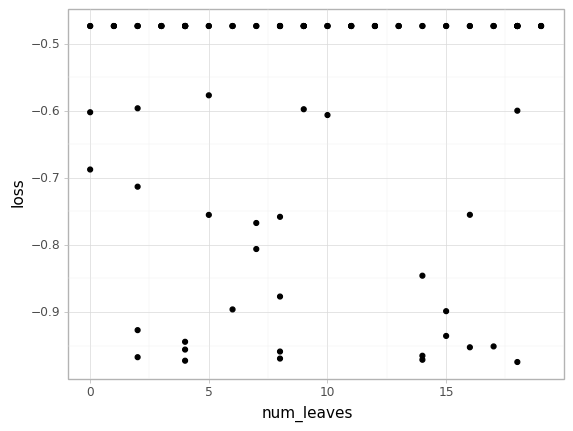

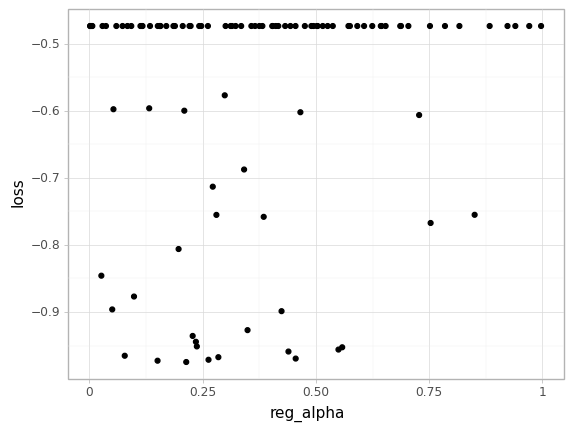

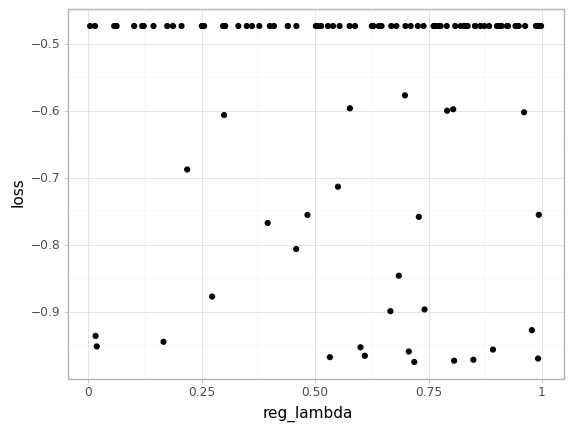

In [40]:
extract_and_plot_hyperopt_trials(trials_lgbm)

In [42]:
lgbm_final = lgb.LGBMClassifier(objective="binary", class_weight='balanced', **hyperopt_params_lgbm)
lgbm_final.fit(X_train_data, y_train_data, categorical_feature = ['name_income_type', 'name_education_type', 'name_housing_type', 'occupation_type'])
train_cv_score_lgbm = cross_val_score(lgbm_final, X_train_data, y_train_data, scoring="average_precision", cv = 5, n_jobs=-1).mean()
print("train cv score: " + str(round(train_cv_score_lgbm, 2)))

[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5


C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.


train cv score: 0.95


In [43]:
test_predictions_lgbm = lgbm_final.predict(X_test_data)
summarise_metrices(y_test = y_test, y_hat = test_predictions_lgbm)

average_precision test: 0.04
f1 test: 0.1
precision test: 0.06
recall test: 0.47


<AxesSubplot:>

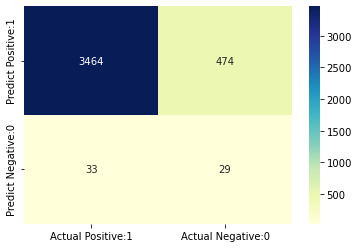

In [44]:
format_confusion_matrix(y_test, test_predictions_lgbm)

In [45]:
test_predictions_lgbm_proba = lgbm_final.predict_proba(X_test_data)

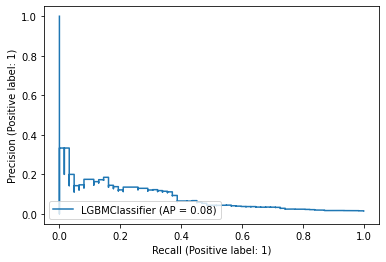

In [46]:
PrecisionRecallDisplay.from_estimator(lgbm_final, X_test_data, y_test)

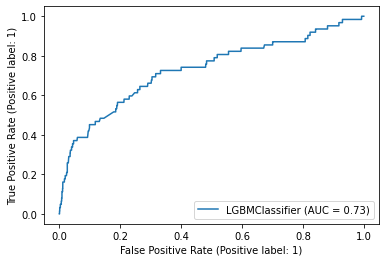

In [47]:
RocCurveDisplay.from_estimator(lgbm_final, X_test_data, y_test)

### Feature importance

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

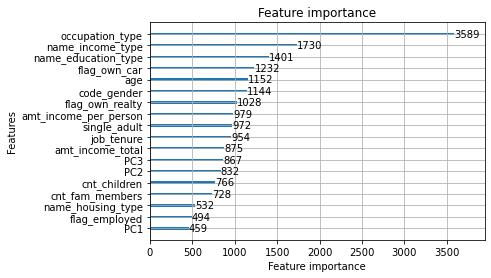

In [48]:
lgb.plot_importance(lgbm_final)

## Hyperparameter tuning for Random Forest

In [49]:
criterion_choices = ["gini", "entropy"]
max_features_choices = ['sqrt', 'log2', None]

rf_reg_params = {
    'n_estimators':     hp.choice('n_estimators', np.arange(5, 3000, 1, dtype=int)),
    'max_depth':        hp.choice('max_depth', np.arange(2, 15, 1, dtype=int)),
    'min_samples_leaf': hp.uniform('min_samples_leaf',0.01, 0.3), 
    'criterion':        hp.choice("criterion", criterion_choices),
    'max_features':     hp.choice('max_features', max_features_choices)        
}

def obj_fun_rf(params):
    rf = RandomForestClassifier(class_weight='balanced', **params)
    rf.fit(X_train_data, y_train_data)
    train_cv_score = cross_val_score(rf, X_train_data, y_train_data, scoring="average_precision", cv = 5).mean()
    return -1.0 * train_cv_score

X_train_data = X_train_balanced_one_hot
y_train_data = y_train_balanced_one_hot
X_test_data = X_test_one_hot
y_test_data = y_test
        
trials_rf = Trials()
hyperopt_params_rf = fmin(
    fn = obj_fun_rf,                 # objective function
    space = rf_reg_params,           # parameter space
    algo = tpe.suggest,              # surrogate algorithm
    max_evals = 100,                 # no. of evaluations
    trials = trials_rf,              # trials object that keeps track of the sample results (optional)
    rstate = np.random.default_rng(seed)
)

100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [26:05<00:00, 15.66s/trial, best loss: -0.7377668550917711]


In [50]:
hyperopt_params_rf

{'criterion': 0,
 'max_depth': 6,
 'max_features': 2,
 'min_samples_leaf': 0.011428378642866208,
 'n_estimators': 2233}

In [51]:
hyperopt_params_rf = {'criterion': criterion_choices[hyperopt_params_rf['criterion']],
                       'max_depth': hyperopt_params_rf['max_depth'],
                       'max_features': max_features_choices[hyperopt_params_rf['max_features']],
                       'n_estimators': hyperopt_params_rf['n_estimators']}

In [52]:
hyperopt_params_rf

{'criterion': 'gini',
 'max_depth': 6,
 'max_features': None,
 'n_estimators': 2233}

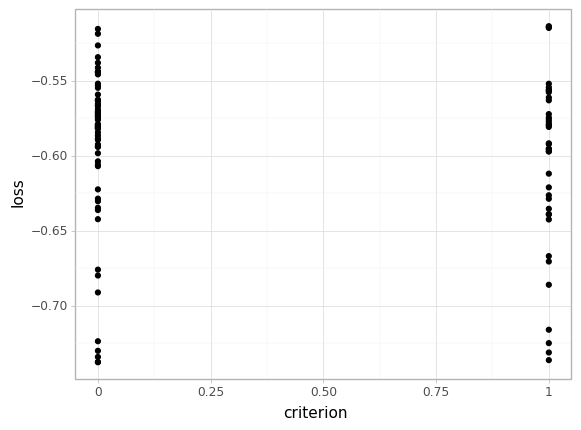

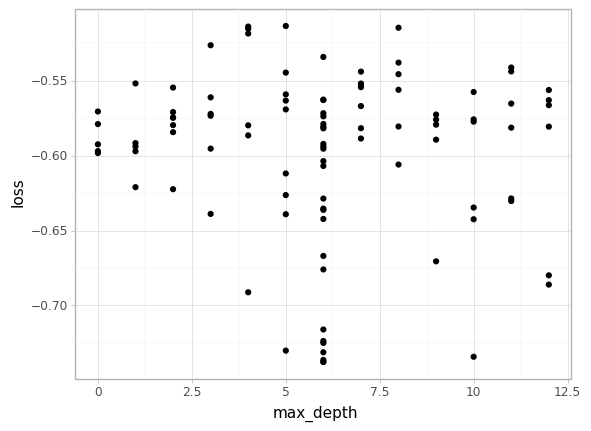

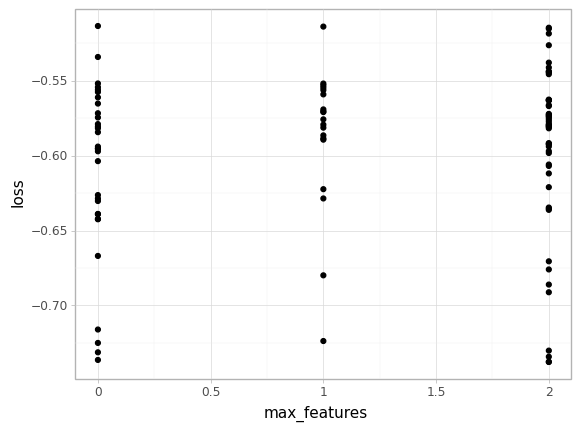

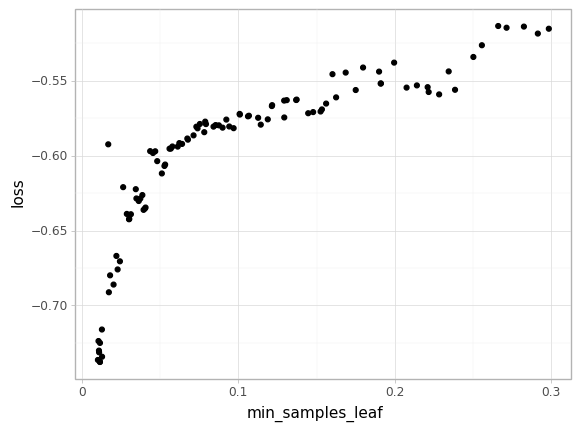

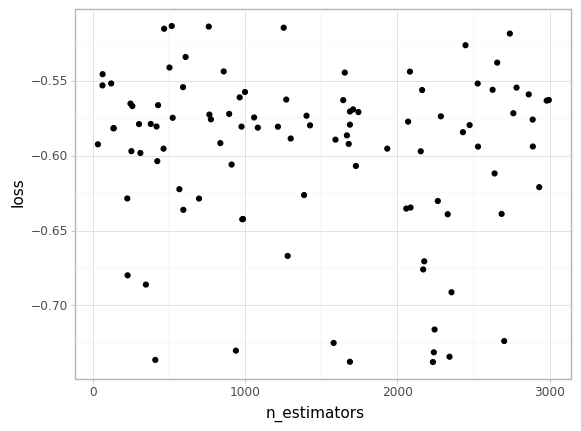

In [53]:
extract_and_plot_hyperopt_trials(trials_rf)

In [55]:
rf_final = RandomForestClassifier(class_weight='balanced', **hyperopt_params_rf)
rf_final = rf_final.fit(X_train_data, y_train_data)
train_cv_score_rf = cross_val_score(rf_final, X_train_data, y_train_data, scoring="average_precision", cv = 5, n_jobs=-1).mean()
print("train cv score: " + str(round(train_cv_score_rf, 2)))

train cv score: 0.81


In [56]:
test_predictions_rf = rf_final.predict(X_test_data)
summarise_metrices(y_test = y_test, y_hat = test_predictions_rf)

average_precision test: 0.02
f1 test: 0.05
precision test: 0.03
recall test: 0.44


<AxesSubplot:>

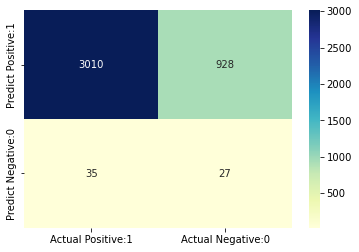

In [57]:
format_confusion_matrix(y_test, test_predictions_rf)

In [58]:
test_predictions_rf_proba = rf_final.predict_proba(X_test_data)

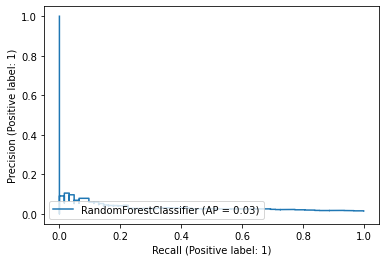

In [59]:
PrecisionRecallDisplay.from_estimator(rf_final, X_test_data, y_test)

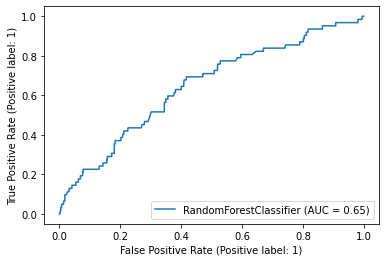

In [60]:
RocCurveDisplay.from_estimator(rf_final, X_test_data, y_test)

### Feature importance

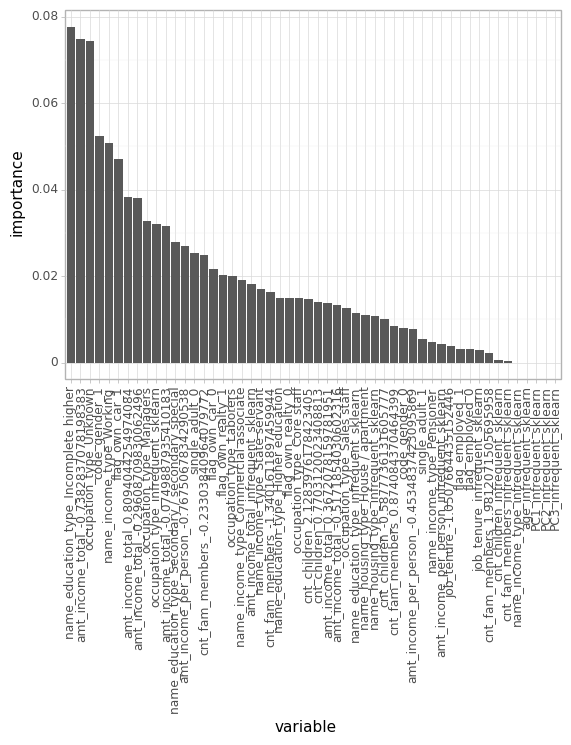

In [61]:
get_rf_feature_imp(rf_final)

# Final classification on test set

In [62]:
final_model = lgbm_final
test_predictions_final = test_predictions_lgbm
test_predictions_proba_final = test_predictions_lgbm_proba

In [63]:
from sklearn.metrics import classification_report
print(classification_report(y_test, test_predictions_final))

              precision    recall  f1-score   support

           0       0.99      0.88      0.93      3938
           1       0.06      0.47      0.10        62

    accuracy                           0.87      4000
   macro avg       0.52      0.67      0.52      4000
weighted avg       0.98      0.87      0.92      4000



In [64]:
tbl_results_roc = pd.DataFrame()
tbl_results_roc['fpr'], tbl_results_roc['tpr'], tbl_results_roc['thresholds'] = roc_curve(y_test, test_predictions_proba_final[:,1])

In [65]:
tbl_results_pr = pd.DataFrame()

precision, recall, thresholds = precision_recall_curve(y_test[:], test_predictions_proba_final[:,1])
thresholds = np.append(thresholds, 1)

tbl_results_pr['precision'] = precision
tbl_results_pr['recall'] = recall
tbl_results_pr['thresholds'] = thresholds
tbl_results_pr['fscore'] = compute_f1(tbl_results_pr.precision, tbl_results_pr.recall)

## Results for default threshold = 0.5

In [66]:
print('Default threshold 0.5')
get_summary(tbl_results_pr, 0.5)

Default threshold 0.5


,precision,recall,thresholds,fscore
1737,0.05754,0.467742,0.497551,0.102473


In [67]:
get_summary(tbl_results_roc, 0.5)

,fpr,tpr,thresholds
156,0.120366,0.467742,0.502619


<AxesSubplot:>

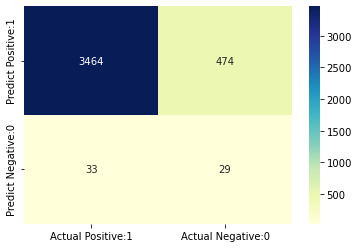

In [68]:
format_confusion_matrix(y_test, test_predictions_final)

## Results for best threshold

In [69]:
# locate the index of the largest f score
ix = np.argmax(tbl_results_pr.fscore)
best_threshold = tbl_results_pr.thresholds[ix]

In [70]:
print('Best Threshold: ' + str(best_threshold))
get_summary(tbl_results_pr, best_threshold)

Best Threshold: 0.8503393699532625


,precision,recall,thresholds,fscore
1886,0.129496,0.290323,0.850339,0.179104


In [71]:
get_summary(tbl_results_roc, best_threshold)

,fpr,tpr,thresholds
61,0.030726,0.290323,0.850339


<AxesSubplot:>

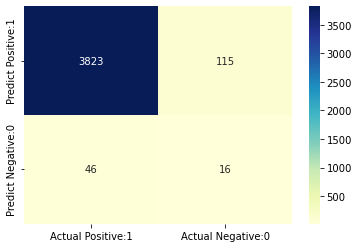

In [72]:
test_predictions_threshold_final = reclassify_by_treshold(test_predictions_proba_final, best_threshold)
format_confusion_matrix(y_test, test_predictions_threshold_final)